# Parameter sensitivity

Are k-MSTs less sensitive to k than k-NNs? Intuitively the answer is yes because
k-MSTs always produce a single connected component for every value of k. That is
not always the case for k-NNs. 

A better question asks how k influences dimensionality reduction performance.
This notebook performs a parameter sensitivity analysis measuring how the
sortedness metric changes for small changes in k: $\Delta k$

In [ ]:
import numba
import warnings
import numpy as np
import pandas as pd
import lensed_umap as lu
from tqdm import tqdm
from itertools import product
from collections import defaultdict
from scipy.stats import weightedtau
from scipy.spatial.distance import cdist

from umap import UMAP
from multi_mst import KMSTDescent

from lib.data import get_datasets
from lib.plotting import *

_ = configure_matplotlib()

## Datasets

We use a set of smaller real-world datasets to evaluate the algorithms because
the sortedness measure has a quadratic computational complexity. These datasets
have been used to evaluate clustering algorithms by [campello et al.,
2015](https://dl.acm.org/doi/abs/10.1145/2733381) and [Castro et al.,
2019](https://link.springer.com/article/10.1007/s10618-019-00651-1).

This repository includes code and/or instructions to download the datasets. See
the respective `notebooks/data/[dataset]/README.md` file for instructions. The
datasets that have been downloaded and/or pre-processed following those
instructions are used.

In [2]:
small_data_config = {
  key: loader 
  for key, loader in  get_datasets().items()
  if loader().shape[0] < 10000
}
print(small_data_config.keys())

dict_keys(['iris', 'diabetes', 'wine', 'articles_1442_5', 'articles_1442_80', 'authorship', 'cardiotocography', 'cell_cycle_237', 'ecoli', 'elegans', 'horse', 'mfeat_factors', 'mfeat_karhunen', 'semeion', 'yeast_galactose'])


## Parameter sweep

This section implements the parameter sensitivity analysis. First, we need a
function to compute k-NN and k-MST graphs and their UMAP embeddings given a
dataset and k.

In [4]:
def compute_embedding(data, k, alg):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore", category=FutureWarning)
        if alg == "kmst":
            p = (
                KMSTDescent(num_neighbors=k, metric="cosine")
                .fit(data)
                .umap(transform_mode="graph")
            )
        elif alg == "umap":
            p = UMAP(
                n_neighbors=k, force_approximation_algorithm=True, metric="cosine"
            ).fit(data, transform_mode="graph")
        p = lu.embed_graph(p, repulsion_strengths=[0.001, 0.01, 0.1, 1])
    return p.embedding_, p.graph_

Second, we need a function that computes the sortedness measure, comparing
distance ranks between the raw data and the embedding:

In [5]:
@numba.njit(parallel=True)
def rank_along_col(orders):
    """Convert per-row argsort order into ranks."""
    out = np.empty(orders.shape, dtype=np.intp)
    for row in numba.prange(orders.shape[0]):
        for i, o in enumerate(orders[row, :]):
            out[row, o] = i
    return out


def score_ranks(a, b):
    """Computes Sortedness from data ranks (a) and embedding ranks (b)."""
    sortedness = np.empty(a.shape[0], dtype=np.float32)
    for idx in range(a.shape[0]):
        sortedness[idx] = weightedtau(a[idx, :], b[idx, :], rank=a[idx, :]).statistic
    return np.mean(sortedness)

Finally, we need to evaluate both algorithms on the datasets at multiple values
of k. Here, we select random values in 10 uniform segments on $k = [2, 100]$.
Each sampled value also gets perturbed with $\pm \Delta k \in [2, 5, 10]$,
randomly selecting the positive or negative direction. The resulting unique
values for $k$ are evaluated and the process is repeated 5 times. The embedding,
graph, and resulting sortedness are stored.

Running this cell took 16 hours.

In [8]:
n_repeats = 5
num_segments = 10
min_sample_range = (2, 100)
deltas = np.array([[2], [5], [10]])
algorithms = ["kmst", "umap"]

# sampled k values
segments = np.linspace(*min_sample_range, num_segments + 1, dtype=int)
samples = np.random.uniform(segments[:-1], segments[1:], size=(n_repeats, num_segments))
min_sample_sizes = np.round(samples).astype(int).T

# perturbed k values
directions = np.random.choice((-1, 1), size=(deltas.shape[0], num_segments, n_repeats))
perturbations = directions * deltas[:, :, np.newaxis]
new_values = min_sample_sizes[np.newaxis, :, :] + perturbations

# parameter sweep
records = []
pbar = tqdm(total=len(small_data_config) * len(algorithms) * n_repeats)
for data_name, loader in small_data_config.items():
    X = loader()
    data_ranks = rank_along_col(np.argsort(cdist(X, X, metric="cosine"), axis=1))
    for r in range(n_repeats):
        all_ks = np.unique(
            np.concatenate((min_sample_sizes[:, r], new_values[:, :, r].flatten()))
        )
        all_ks = all_ks[all_ks >= 2]
        for alg in algorithms:
            for k in all_ks:
                E, g = compute_embedding(X, k, alg)
                embedding_ranks = rank_along_col(
                    np.argsort(cdist(E, E, metric="sqeuclidean"), axis=1)
                )
                sortedness = score_ranks(data_ranks, embedding_ranks)
                records.append(
                    {
                        "repeat": r,
                        "data_set": data_name,
                        "algorithm": alg,
                        "k": k,
                        "embedding": E,
                        "graph": g,
                        "sortedness": sortedness,
                    }
                )
            pbar.update(1)

df = pd.DataFrame.from_records(records)

np.save("./data/generated/sensitivity/deltas.npy", deltas)
np.save("./data/generated/sensitivity/min_sizes.npy", min_sample_sizes)
np.save("./data/generated/sensitivity/perturbed_values.npy", new_values)
df.to_pickle("./data/generated/sensitivity/results.pkl")

100%|██████████| 150/150 [16:13:20<00:00, 24.61s/it]     

## Results

Now we can load the results and create plots to see how the k-NNs and k-MST differ over k.

In [3]:
import numpy as np
import pandas as pd
from lib.plotting import *
from lib.drawing import regplot_lowess_ci

tab10 = configure_matplotlib()
deltas = np.load("./data/generated/sensitivity/deltas.npy")
min_sample_sizes = np.load("./data/generated/sensitivity/min_sizes.npy")
new_values = np.load("./data/generated/sensitivity/perturbed_values.npy")
df = pd.read_pickle("./data/generated/sensitivity/results.pkl")
ks = sorted(df.k.unique())
algorithms = df.algorithm.unique()
datasets = sorted(df.data_set.unique())

In [4]:
print(datasets)

['articles_1442_5', 'articles_1442_80', 'authorship', 'cardiotocography', 'cell_cycle_237', 'diabetes', 'ecoli', 'elegans', 'horse', 'iris', 'mfeat_factors', 'mfeat_karhunen', 'semeion', 'wine', 'yeast_galactose']


We use nicely formatted names in the plots:

In [6]:
def to_display_name(input):
    if input.startswith("k"):
        return f"$k$-{input[1:].upper()}"
    if input == 'umap':
        return "$k$-NN"
    return input.upper()


def dataset_name(input):
    names = dict(
        articles_1442_5="Articles-1442-5",
        articles_1442_80="Articles-1442-80",
        audioset="AudioSet (music)",
        authorship="Authorship",
        cardiotocography="CTG",
        cell_cycle_237="CellCycle-237",
        cifar_10="CIFAR-10",
        diabetes="Diabetes",
        ecoli="E.~Coli",
        elegans="C.~Elegans",
        fashion_mnist="Fashion-MNIST",
        horse="Horse",
        iris="Iris",
        mfeat_factors="Mfeat-Factors",
        mfeat_karhunen="Mfeat-Karhunen",
        mnist="MNIST",
        newsgroups="20 Newsgroups",
        semeion="Semeion Digits",
        wine="Wine",
        yeast_galactose="YeastGalactose",
    )
    return names.get(input, input)

### Sortedness over $k$ per dataset

This section draws the average sortedness over k for all datasets. Generally, we
see stable performance on both algorithms. The k-NN requires a slightly larger
k-value to reach its performance peak. The k-MST performs well on very low k
values. On the other hand, its performance drops at higher k-values.

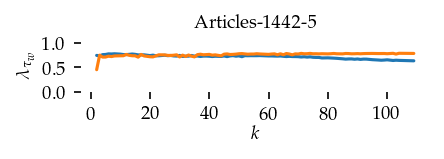

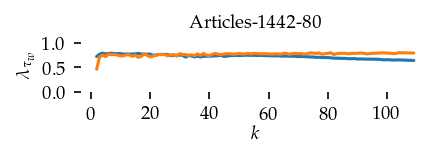

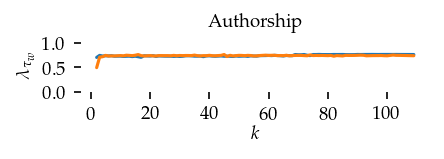

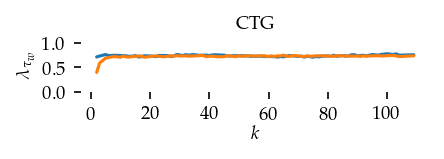

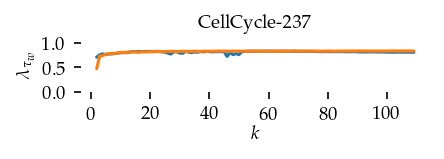

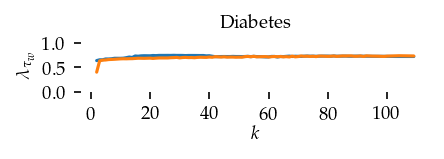

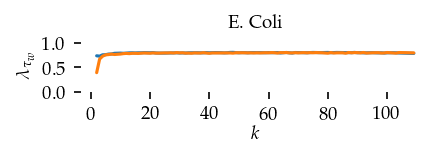

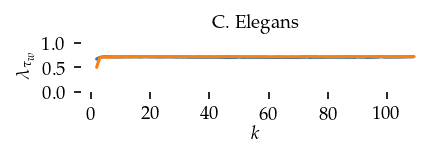

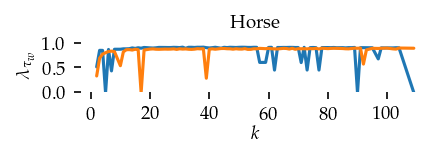

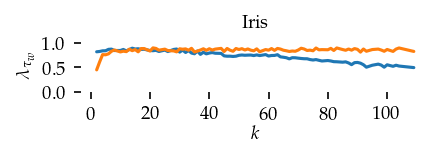

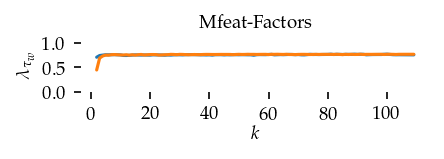

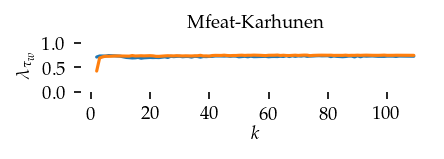

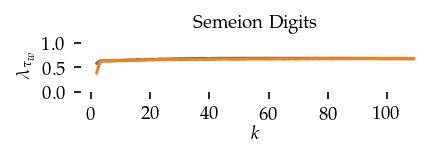

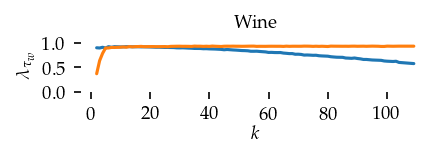

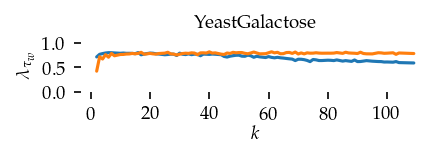

In [16]:
for i, data_name in enumerate(datasets):
    sized_fig(0.5, 0.618 / 2)
    ddf = df.query(f'data_set == "{data_name}"')
    max_x = ddf.k.max()
    max_y = ddf.sortedness.max()

    sns.lineplot(
        data=ddf,
        x="k",
        y="sortedness",
        hue="algorithm",
        errorbar=None,
        palette="tab10",
        legend=False,
    )
    plt.title(dataset_name(data_name), fontsize=fontsize['small'])
    plt.ylabel(r"$\lambda_{\tau_w}$")
    plt.xlabel("$k$", labelpad=0)
    plt.ylim(0, 1.05)
    plt.yticks([0, 0.5, 1.0])
    plt.subplots_adjust(bottom=0.38, right=1.01, left=0.16, top=0.78)
    plt.savefig(f"images/sortedness_curves_{data_name}_umap_layout.pdf", pad_inches=0)
plt.show()

### Interpolated curve shape:

To summarize these figures we Lowess interpolate k to the sortedness values
considering all datasets. First, we scale the sortedness values by the maximum
value observed per dataset so the result captures the curves' shapes while
ignoring absolute performance.

In [19]:
def scale_quality(group):
    max_q = group.sortedness.max()
    group["scaled_quality"] = group.sortedness / max_q
    return group


df = df.groupby(["data_set"]).apply(scale_quality, include_groups=False).reset_index()

The resulting figure confirms the previously mentioned patterns: k-MST performs
better than k-NN at low k-values (k < 10).

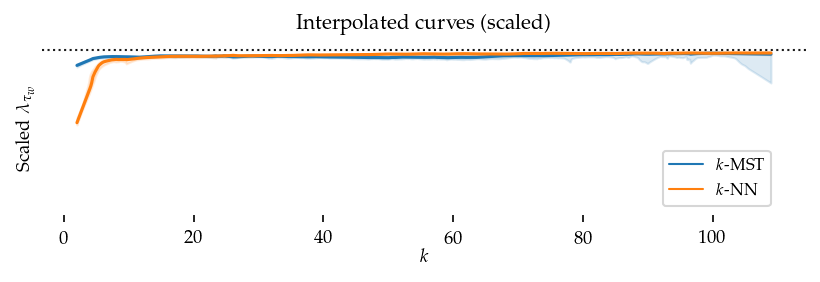

In [99]:
sized_fig(1, 0.618 / 2)
max_y = df.scaled_quality.max()
plt.title("Interpolated curves (scaled)")
plt.axhline(y=1, xmin=0, xmax=100, color="k", linestyle=":", linewidth=1)
for j, alg in enumerate(algorithms):
    regplot_lowess_ci(
        df.query(f'algorithm == "{alg}"'),
        x="k",
        y="scaled_quality",
        ci_level=95,
        n_boot=100,
        lowess_frac=0.05,
        color=tab10[j],
        scatter=False,
    )
plt.legend(
    loc="lower right",
    bbox_to_anchor=(0.965, 0),
    handles=[
        plt.Line2D([0], [0], color=tab10[i], lw=1, label=to_display_name(alg))
        for i, alg in enumerate(algorithms)
    ],
)
plt.ylabel(r"Scaled $\lambda_{\tau_w}$")
plt.xlabel("$k$", labelpad=0)
plt.ylim(0, 1.05)
plt.yticks([])
plt.subplots_adjust(bottom=0.2, right=1.02, left=0.09, top=0.88)
plt.savefig(f"images/sortedness_curves_scaled_umap_layout.pdf", pad_inches=0)
plt.show()

Second, we perform the same interpolation without re-scaling the sortedness.
These curves show (local) average sortedness over all datasets. Here, the
performance difference at higher k-values (k > 50) is also visible.

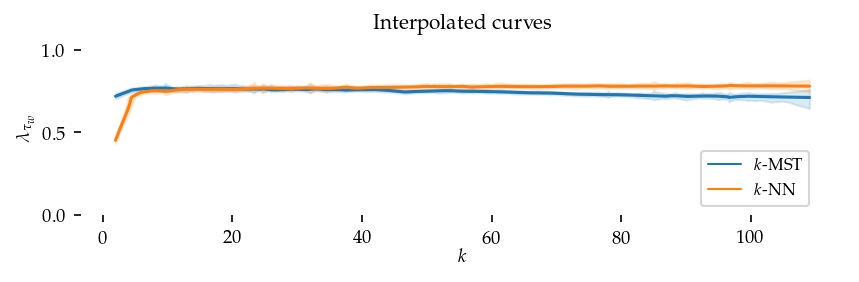

In [100]:
sized_fig(1, 0.618 / 2)
max_y = df.sortedness.max()
plt.title("Interpolated curves")
for j, alg in enumerate(algorithms):
    regplot_lowess_ci(
        df.query(f'algorithm == "{alg}"'),
        x="k",
        y="sortedness",
        ci_level=95,
        n_boot=100,
        lowess_frac=0.05,
        color=tab10[j],
        scatter=False,
    )
plt.legend(
    loc="lower right",
    bbox_to_anchor=(0.965, 0),
    handles=[
        plt.Line2D([0], [0], color=tab10[i], lw=1, label=to_display_name(alg))
        for i, alg in enumerate(algorithms)
    ],
)
plt.ylabel(r"$\lambda_{\tau_w}$")
plt.xlabel("$k$", labelpad=0)
plt.ylim(0, 1.05)
plt.yticks([0, 0.5, 1.0])
plt.subplots_adjust(bottom=0.2, right=1.02, left=0.09, top=0.88)
plt.savefig(f"images/sortedness_curves_interpolated_umap_layout.pdf", pad_inches=0)
plt.show()

### Sensitivity boxplots

The sensitivity analysis computes an average absolute ratio comparing the original and perturbed k values: 
$$
  s_{\Delta v} = \frac{1}{|V|} \sum_{v \in V} \left|\frac{\lambda_{\tau_w}(k=v \pm \Delta v) - \lambda_{\tau_w}(k=v)} {\lambda_{\tau_w}(k=v \pm\Delta v) + \lambda_{\tau_w}(k=v)}\right|,
$$
where $V$ is the set of sampled k-values.

This cell computes the sensitivity scores for each dataset.

In [ ]:
sensitivity_records = []
for data_set, alg_id in product(datasets, algorithms):
    sub_df = df.query(f"data_set == '{data_set}' & algorithm == '{alg}'")
    vals = defaultdict(
        lambda: np.nan,
        {(r, k): v for r, k, v in zip(sub_df.repeat, sub_df.k, sub_df.sortedness)},
    )
    lookup_fun = np.vectorize(lambda r, x: vals[(r, x)])
    initial_val = np.hstack(
        [lookup_fun(i, min_sample_sizes[:, i])[:, None] for i in range(n_repeats)]
    )
    perturbed_val = np.concatenate(
        [lookup_fun(i, new_values[:, :, i])[:, :, None] for i in range(n_repeats)],
        axis=2,
    )
    with np.errstate(divide="ignore", invalid="ignore"):
        diff = np.abs((perturbed_val - initial_val) / (perturbed_val + initial_val))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        sensitivity = np.nanmean(diff, axis=(1, 2))
    for delta, sensitivity in zip(deltas[:, 0], sensitivity):
        sensitivity_records.append(
            {
                "data_set": data_set,
                "alg_id": alg_id,
                "perturbation": delta,
                "sensitivity": sensitivity,
            }
        )

# Convert to pandas
df_sens = pd.DataFrame.from_records(sensitivity_records)
df_sens.head()

,data_set,alg_id,perturbation,sensitivity
0,articles_1442_5,kmst,2,0.006424
1,articles_1442_5,kmst,5,0.007088
2,articles_1442_5,kmst,10,0.011807
3,articles_1442_5,umap,2,0.006424
4,articles_1442_5,umap,5,0.007088


There is no visible difference between the sensitivity distributions because the
sortedness curves are very flat except at k<10.

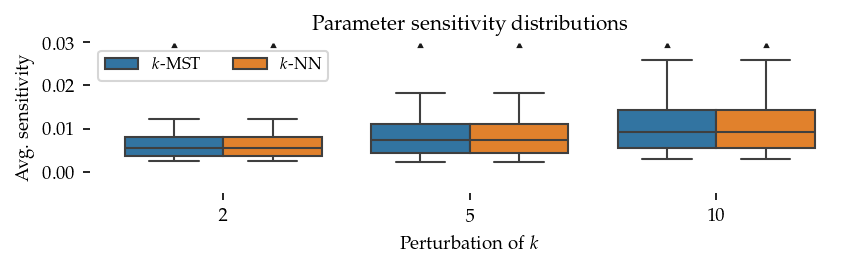

In [80]:
sized_fig(1, 0.8 / 3)

ax = sns.boxplot(
    data=df_sens,
    y=df_sens.sensitivity,
    x=pd.Categorical(df_sens.perturbation),
    hue=df_sens.alg_id.apply(to_display_name),
    palette=tab10[:2],
    fliersize=0.5,
    linewidth=1,
    legend=True,
)
max_y = 0.03
df_sens.sensitivity > max_y
u_perts = df_sens.perturbation.unique().tolist()
for (alg_id, perturbation), _ in (
    df_sens[df_sens.sensitivity > max_y]
    .groupby(["alg_id", "perturbation"])
    .groups.items()
):
    pert_order = u_perts.index(perturbation)
    alg_order = algorithms.tolist().index(alg_id)
    w = 0.8/2
    o = pert_order - w + (alg_order) * w / 1 + w / 2
    plt.plot(o, max_y - 0.0007, 'k^', markersize=1.5)

# plt.yticks([0, 0.05, 0.1])
plt.ylim(-0.005, max_y)
plt.legend(ncol=4, title="", loc="upper left")
plt.xlabel("Perturbation of $k$")
plt.ylabel("Avg.~sensitivity")
plt.title("Parameter sensitivity distributions")
plt.subplots_adjust(left=0.075, right=1, bottom=0.21, top=0.9)
plt.show()

### Sortedness distributions

This cell provides an alternative visualization to the interpolated curves.
Here, the sortedness is shown in boxplots for segments of k spanning 5 values.
The boxplots contain more information than the mean with its confidence
interval.

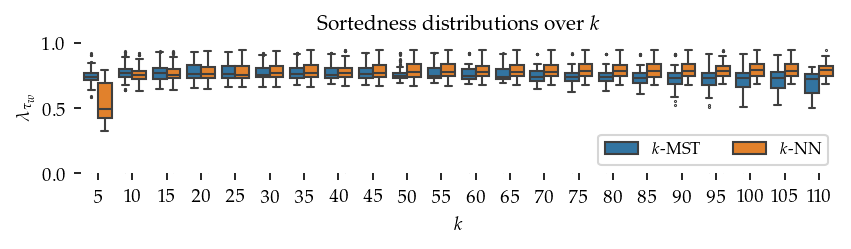

In [96]:
sized_fig(1, 0.8 / 3)

ax = sns.boxplot(
    data=df,
    y=df.sortedness,
    x=pd.Categorical(df.k // 5),
    hue=df.algorithm.apply(to_display_name),
    palette=tab10[:2],
    fliersize=0.5,
    linewidth=1,
    legend=True,
)

plt.ylim(-0.005, 1.005)
plt.yticks([0, 0.5, 1])
xticks = plt.xticks()[0]
plt.xticks(xticks)
plt.gca().set_xticklabels([f"{(tick + 1) * 5}" for tick in xticks])
plt.legend(ncol=4, title="", loc="lower right")
plt.xlabel("$k$")
plt.ylabel("$\\lambda_{\\tau_w}$")
plt.title("Sortedness distributions over $k$")
plt.subplots_adjust(left=0.08, right=1, bottom=0.27, top=0.87)
plt.savefig(f"images/sortedness_boxplots_umap_layout.pdf", pad_inches=0)
plt.show()

### Individual layouts

Finally, we draw the edges of the best layout per dataset for select $k$ values.

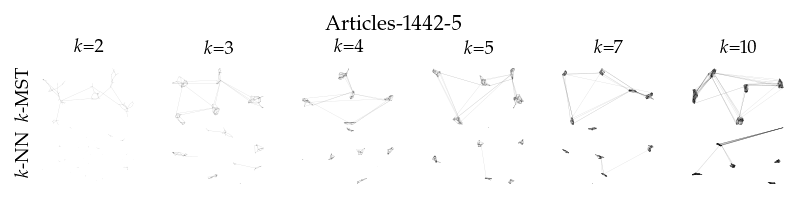

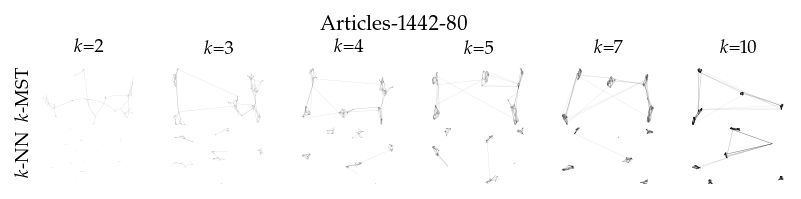

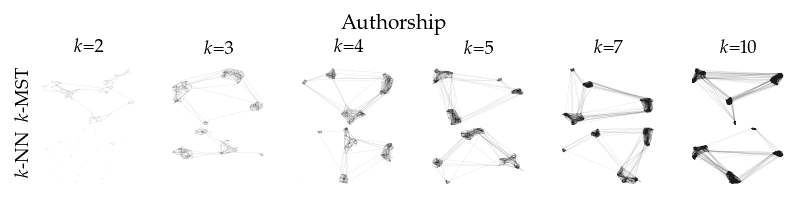

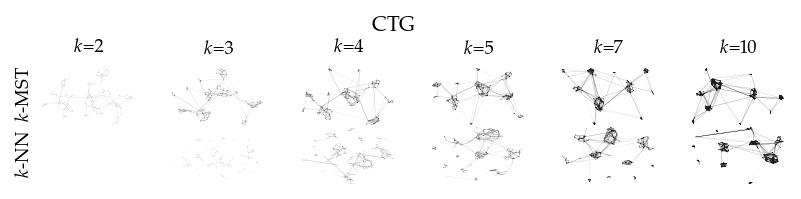

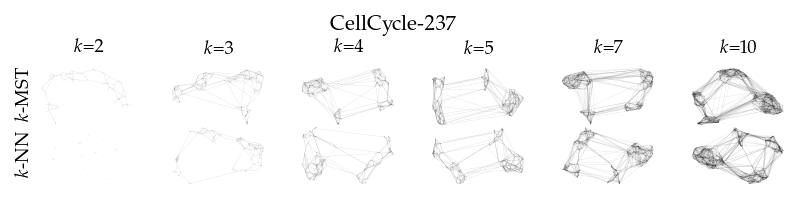

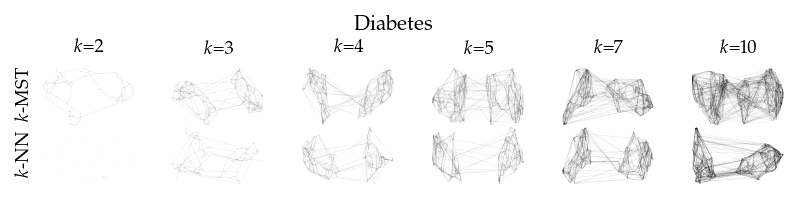

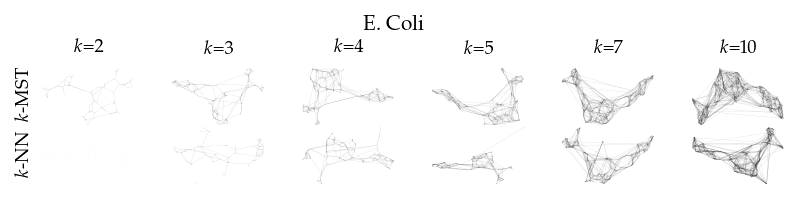

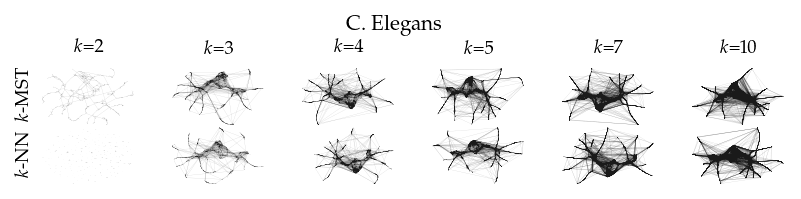

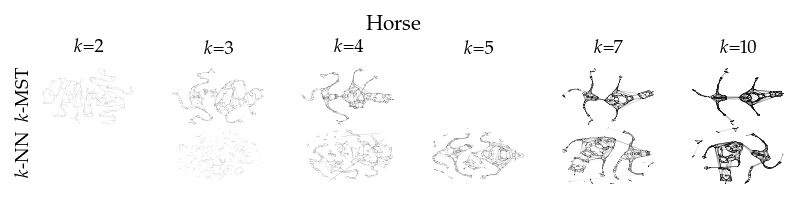

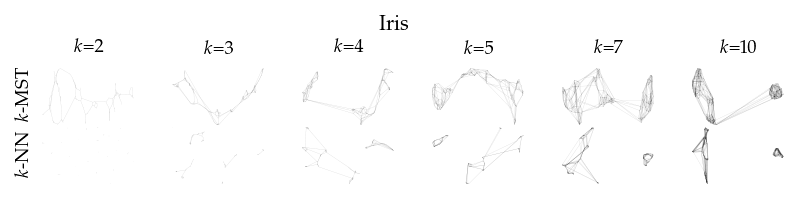

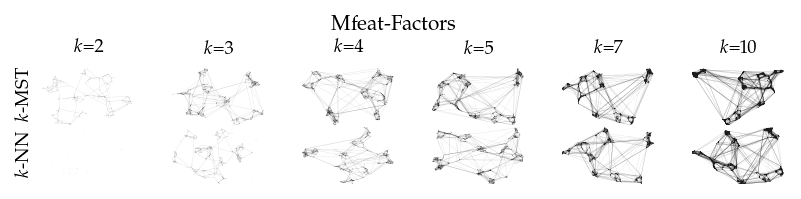

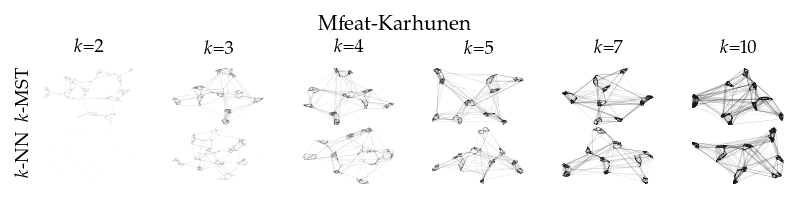

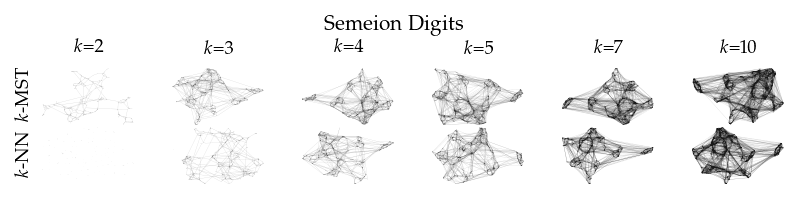

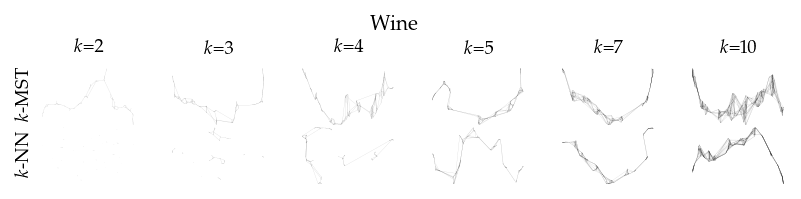

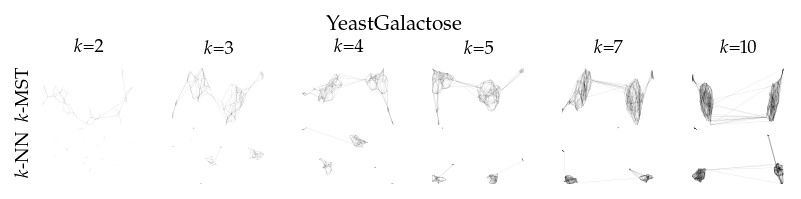

In [8]:
from sklearn.decomposition import PCA
from matplotlib.collections import LineCollection


plot_ks = [2, 3, 4, 5, 7, 10]
for data_set in datasets:
    sized_fig(1, 0.618 / 6 * 2)
    for i, (alg, k) in enumerate(product(algorithms, plot_ks)):
        plt.subplot(len(algorithms), len(plot_ks), i + 1)
        rows = df.query("data_set == @data_set & k == @k & algorithm == @alg")
        idx = np.argmax(rows.sortedness)
        embedding = rows.embedding.iloc[idx]
        if not np.any(np.isnan(embedding)):
            embedding = PCA().fit_transform(embedding)
        embedding -= embedding.min(axis=0)
        embedding /= embedding.max(axis=0)
        embedding *= np.array([[1.618, 1]])
        graph = rows.graph.iloc[idx].tocoo()
        row, col = graph.row, graph.col
        plt.gca().add_collection(
            LineCollection(
                np.hstack((embedding[row], embedding[col])).reshape(-1, 2, 2),
                alpha=0.1,
                linewidths=0.1,
                color="k",
            )
        )
        plt.xlim(0, 1.668)
        plt.ylim(0, 1.05)
        plt.xticks([])
        plt.yticks([])
        frame_off()
        if alg == algorithms[0]:
            plt.title(f"$k$={k}", fontsize=fontsize["small"])
        if k == plot_ks[0]:
            plt.ylabel(to_display_name(alg), fontsize=fontsize["small"])
        plt.suptitle(dataset_name(data_set), fontsize=fontsize["normal"], y=1, va="top")
    plt.subplots_adjust(0.05, 0, 1, 0.7, 0, 0)
    plt.savefig(f"images/umap_layouts_{data_set}.png", pad_inches=0)
plt.show()